In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import TrashIm 
import matplotlib.image as mpimg
%matplotlib inline

In [14]:
dateArr = ['01_24_bRAW']
dInd = 0
refdate = dateArr[dInd]

MSIs = glob.glob('D:\\'+refdate+'\\MS\\MultiSpec*.npy')
MST = np.load('D:\\'+refdate+'\\MS\\tstamps.npy')
thermT = np.load('D:\\'+refdate+'\\Thermal\\tstamps.npy')
therms = glob.glob('D:\\'+refdate+'\\Thermal\\Thermal*.npy')

#colT = np.load('D:\\'+refdate+'\\Color\\tstamps.npy')
#colors = glob.glob('D:\\'+refdate+'\\Color\\Color*.npy')
#Calibration Plate
calCurve0 = np.load('C:\\project\\datasetCreation\\utilImages\\calCurve.npy')

#Cross talk correction and demosaic/downsample
c0 = np.load('C:\\project\\datasetCreation\\utilImages\\correction0.npy')
c1 = np.load('C:\\project\\datasetCreation\\utilImages\\correction1.npy')
correction = c0+c1
correction = correction/2.0

#Homography matrix
H = np.load('CamMatrices\\HomographyTherm2.npy')
H1 = np.load('CamMatrices\\HomographyColor.npy')

#Flatfield Correction
dark = (np.load('C:\\project\\datasetCreation\\utilImages\\darkmosaic.npy') +np.load('C:\\project\\datasetCreation\\utilImages\\darkmosaic1.npy') + 
        np.load('C:\\project\\datasetCreation\\utilImages\\darkmosaic2.npy')) / 3.0
light = np.load('C:\\project\\datasetCreation\\utilImages\\12_07_dfield.npy')

print(len(thermT))
print(len(MSIs))
#print(len(colT))

71682
13221


13221


(0.0, 1.1)

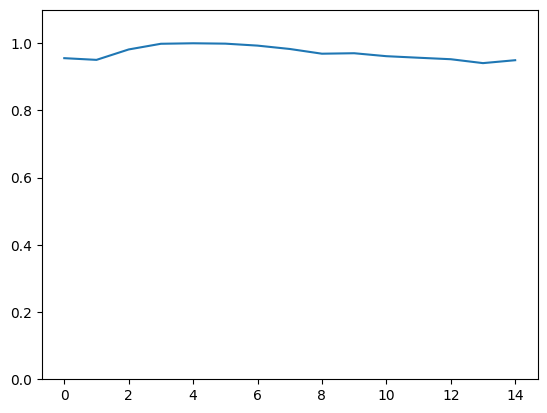

In [15]:
#time sync - approx but still pretty solid
stamps = TrashIm.tsync(MST,thermT)
#stampsC = TrashIm.tsync(MST,colT)
print(len(stamps))
#print(len(stampsC))
plt.plot(calCurve0)
plt.ylim(0,1.1)

1023


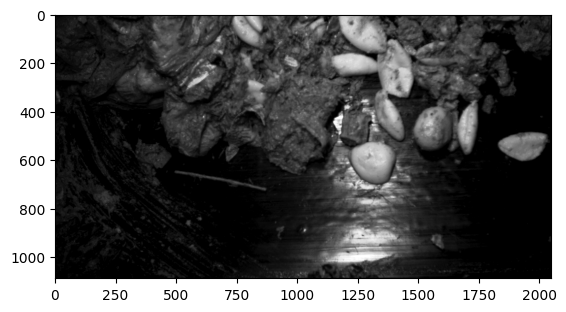

In [16]:
#interesting points -- 01/09
#2800 -- coffee grounds
#901 -- aluminum can
#1799 -- lots of plastic (lesnack)
#500 goo and belt


##01/24
###8000 -- dark and saturated
###20 -- fruit
##1500 -- few items
##1800 -- big plastic
##2000 -- veggies
##4000 -- big plastic
##4100 -- lots of objects
##4200 -- lots of plastics
##6200 -- oranges

MSind = 5
THind = stamps[MSind]
#Cind = stampsC[MSind]
inputIm = np.load(MSIs[MSind])
inputIm = inputIm*(inputIm>0)
inputm = inputIm/1023
print(np.max(inputIm))
plt.imshow(inputIm*(inputIm>50),'gray')
np.save('RawMSCapstone',inputIm)

22.248013215906433


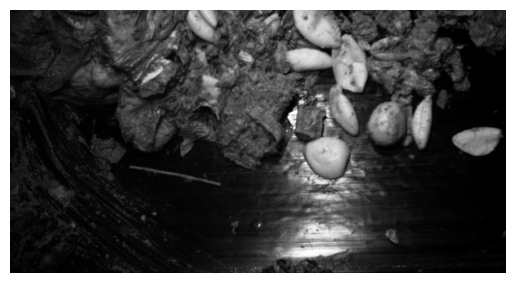

In [17]:
histo = TrashIm.image_histogram_equalization(inputIm,30)
hist = histo[0]
plt.imshow(hist,'gray')
plt.axis("off")
print(np.min(hist))

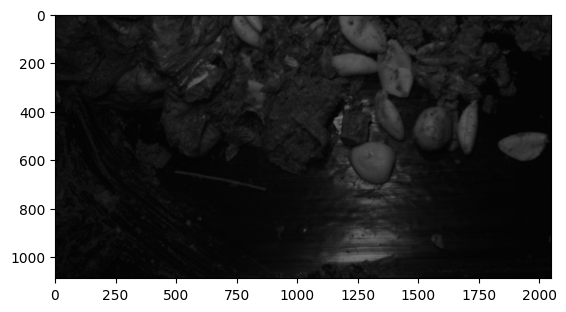

In [18]:
#ffieldIm =inputIm.copy()# TrashIm.ffield(inputIm,light,dark)
ffieldIm = TrashIm.ffield(inputIm,light,dark)
plt.imshow(ffieldIm,'gray')

In [19]:
#imageMosaic = np.uint16(imageMosaic)
bands = [609.0, 625.6, 648.0, 666.3, 683.9, 700.8, 718.9, 736.6, 754.1, 770.1, 786.2, 802.4, 818.3, 833.1, 849.4]
wb = TrashIm.interp(ffieldIm)
print('Bilinear Interp')
#SD = TrashIm.SDInterp(inputIm)
#print('Spectral Diff')

Bilinear Interp


In [20]:
#imageMosaic = SD.copy()
imageMosaic = wb.copy()
test = np.dot(imageMosaic,correction.T)
imageMosaic = test/calCurve0

0.0012124800000000002


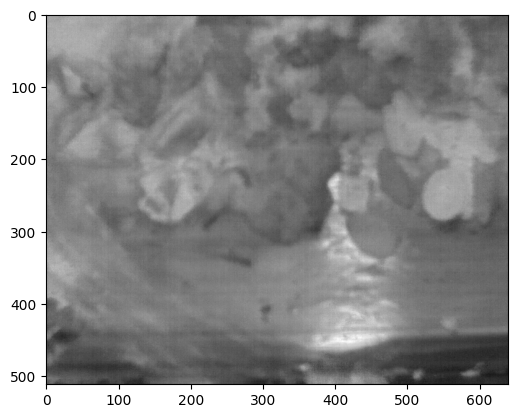

In [21]:
therm = np.load(therms[THind])
plt.imshow(therm)
tdiff = 1e-9*(thermT[THind] - MST[MSind])
print(tdiff)

In [22]:
np.save('matchedThermalCapstone',therm[:,:,0])

In [ ]:
dstMS, dstTH,dstC = TrashIm.undistort(imageMosaic,therm,color=0)
imwarp = TrashIm.applyHom(dstTH,H,dstMS.shape[1],dstMS.shape[0])
#cwarp = TrashIm.applyHom(dstC,H1,dstMS.shape[1],dstMS.shape[0])
fullIm = TrashIm.stack(dstMS,imwarp)
#fullIm = np.dstack([cwarp,fullIm])
spectral = fullIm[:,:,:-1]
print(fullIm.shape)

In [ ]:
#plt.imshow(cwarp)
#np.save('C:\\project\\Tutorials_Practice\\aligned4',fullIm)

In [ ]:
ind = 6
al1 = 0.1
al2 = 1-al1
blend = spectral[:,:,0]*al1 + fullIm[:,:,-1]*al2
x1 = 380
y1 = 300

x2 = 510
y2 = 420
plt.imshow(blend,'gray')

In [ ]:
x1 = 50
y1 = 1250

x2 = 200
y2 = 1600

x3 = 400
y3 = 950

#x4 = 200
#y4 = 740

#x5 = 300
#y5 = 240
ind = 11
thresh = max(np.min(spectral),0)
print(np.min(spectral))
threshed = spectral*(spectral>thresh)
plt.imshow(threshed[:,:,-1],'gray')
print(np.max(spectral))
plt.scatter(y1,x1,c='r')
plt.scatter(y2,x2,c='g')
plt.scatter(y3,x3,c='b')

In [ ]:
plot1 = spectral[x1,y1,:]#/np.max(imageMosaic[x1,y1,:])
plot2 = spectral[x2,y2,:]#/np.max(imageMosaic[x2,y2,:])
plot3 = spectral[x3,y3,:]#/np.max(imageMosaic[x3,y3,:])
plt.plot(plot1,c='r',linestyle='--',label = 'conveyor')
plt.plot(plot2,c='g',linestyle='--',label = '?')
plt.plot(plot3,c='b',linestyle='--',label = 'bagged food')
plt.title('Overview')
plt.xlabel('Wavelength')
plt.ylabel('Reflectance (normalized)')
plt.legend(loc=0)

In [ ]:
veg = TrashIm.NDVI(spectral)
vegI = (veg[1]>-1.0)*(veg[1]<1.0)*veg[1]
vegI[np.isnan(vegI)] = 0
print(np.min(vegI))
print(np.max(vegI))
plt.imshow(vegI,'gray')


In [ ]:
mids = TrashIm.midFeat(threshed)
mids = mids*(mids>-5)#50*(mids<800)
plt.imshow(mids,'gray')

In [ ]:
mapp = np.dstack([fullIm[:,:,-1]/255]*15)
multispec = fullIm[:,:,:-1] *mapp
multispec.shape

In [ ]:
plt.imshow(multispec[:,:,-1],'gray')

In [ ]:
plot1 = multispec[x1,y1,:]#/np.max(imageMosaic[x1,y1,:])
plot2 = multispec[x2,y2,:]#/np.max(imageMosaic[x2,y2,:])
plot3 = multispec[x3,y3,:]#/np.max(imageMosaic[x3,y3,:])
plt.plot(plot1,c='r',linestyle='--',label = 'conveyor')
plt.plot(plot2,c='g',linestyle='--',label = '?')
plt.plot(plot3,c='b',linestyle='--',label = 'bagged food')
plt.title('Overview')
plt.xlabel('Wavelength')
plt.ylabel('Reflectance (normalized)')
plt.legend(loc=0)

In [ ]:
ffieldIm.shape